In [1]:
using Flux
using JLD
using PyPlot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
x = dataset.data[:,dataset.labels.==0]

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

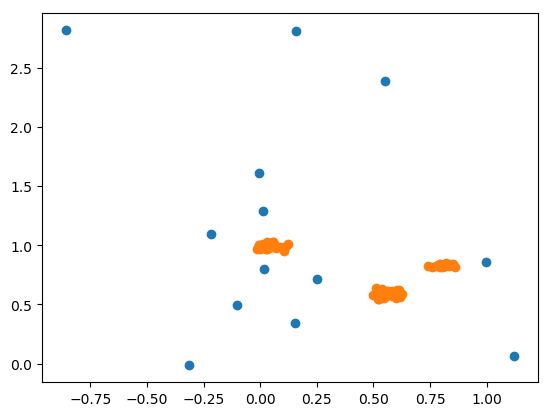

In [3]:
figure()
X = dataset.data
y = dataset.labels
scatter(X[1, y.==1], X[2, y.==1])
scatter(X[1, y.==0], X[2, y.==0])
show()

In [4]:
# VAE settings
indim = size(x,1)
hiddendim = 10
latentdim = 2
nlayers = 2
# (2, 2, 2) does not work
# if this is (2,1,1), basically the output of the net is mean of the data

# setup the VAE object
lambda = 1
L = 100 # samples for classification
# arguments: 4 problem dimensions, 
# predict threshold, contamination level, iterations, throttle, verbal fit
model = VAEmodel(indim, hiddendim, latentdim, nlayers, lambda, 0, 0.1, 50, 1, true, L)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 2))), 1, 0, 0.1, 50, 1, true, 100)

In [5]:
# fit the model
model.lambda = 0.00005
model.verbfit = false
while AnomalyDetection.rerr(model, x).data[1] > 0.002
    AnomalyDetection.fit!(model, x)
    AnomalyDetection.evalloss(model, x)
end

loss: 0.45461722946427163
reconstruction error: 0.463876085532268
KL: 54.74654662597875

loss: 0.303001203509386
reconstruction error: 0.2912326993311968
KL: 70.94494426476335

loss: 0.17350583833487132
reconstruction error: 0.17437137291293722
KL: 93.39337963714878

loss: 0.1270921665109904
reconstruction error: 0.11797324448448576
KL: 133.03583260778726

loss: 0.0961221444943666
reconstruction error: 0.08807557951493218
KL: 146.98547906828995

loss: 0.07610599052265948
reconstruction error: 0.0670849357129702
KL: 164.1991854803508

loss: 0.054806894096952746
reconstruction error: 0.04340106656689259
KL: 191.02287177698878

loss: 0.03582399252117113
reconstruction error: 0.02643977059716353
KL: 202.70555772493702

loss: 0.024555861163436547
reconstruction error: 0.014762126125941001
KL: 197.81766836605632

loss: 0.022060033581136985
reconstruction error: 0.011723121588228302
KL: 182.52989139938026

loss: 0.019869742807533765
reconstruction error: 0.011655385630278358
KL: 167.455241570

In [7]:
model(x)

Tracked 2×90 Array{Float64,2}:
 0.797223  0.723345  0.798508  0.799982  …  0.0735508  0.0670258  0.131218
 0.822205  0.753491  0.825012  0.828234     0.987119   0.987969   0.977635

In [8]:
x

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [9]:
AnomalyDetection.mu(model, x)

Tracked 2×90 Array{Float64,2}:
 -0.045129   -0.086381    -0.0587673   …  -1.25886   -1.35253   -1.21258 
 -0.0034623  -0.00534564  -0.00394294      0.017102   0.010824   0.013546

In [10]:
AnomalyDetection.sigma(model,x)

Tracked 2×90 Array{Float64,2}:
 0.132221  0.129492  0.131023  0.125379  …  0.0987773  0.0931758  0.10018 
 0.987751  0.987554  0.987798  0.987792     0.987609   0.987066   0.986882

In [11]:
AnomalyDetection.sample_z(model, x)

Tracked 2×90 Array{Float64,2}:
 -0.0227726  -0.315064  -0.145396  …  -1.26313   -1.34327  -1.10037 
 -0.474097    1.54179    0.436791     -0.214716  -2.00857   0.337504

In [12]:
# predict labels
X = dataset.data
y = dataset.labels
model.contamination = size(y[y.==1],1)/size(y, 1)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0

In [13]:
model.verbfit = false
tryhat, tsthat = AnomalyDetection.quickvalidate!(dataset, dataset, model)


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 90
  fp = 0
  fn = 1
precision: 1.0
recall: 0.9230769230769231
f1score: 0.96
equal error rate: 0.038461538461538464

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 90
  fp = 0
  fn = 1
precision: 1.0
recall: 0.9230769230769231
f1score: 0.96
equal error rate: 0.038461538461538464


([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [14]:
using ScikitLearn.Utils: meshgrid

In [15]:
# plot heatmap of the fit
figure()
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.rerr(model, [xx[i,j], yy[i,j]]).data[1]
    end
end
contourf(xx, yy, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g")
b = AnomalyDetection.generate_sample(model).data
scatter(b[1], b[2], c = "y", label = "generated sample")
legend()
show()

LoadError: [91mtype Array has no field data[39m

In [20]:
AnomalyDetection.generate_sample(model)

Tracked 2-element Array{Float64,1}:
 0.195024
 0.815235

## what about the LODA data?

In [80]:
master_path = "../../data/Loda/public/datasets/numerical"
folders = readdir(master_path);
datasets = AnomalyDetection.loaddata(master_path);

In [82]:
for key in keys(datasets)
    M, N = size(get(datasets, key, 0).normal)
    print("$(key): M = $M, Nn = $N, ")
    M, N = size(get(datasets, key, 0).easy)
    print("Ne = $N, ")
    M, N = size(get(datasets, key, 0).medium)
    print("Nm = $N, ")
    M, N = size(get(datasets, key, 0).hard)
    print("Nh = $N, ")
    M, N = size(get(datasets, key, 0).very_hard)
    print("Nvh = $N\n")    
end

breast-cancer-wisconsin: M = 30, Nn = 357, Ne = 188, Nm = 18, Nh = 5, Nvh = 0
miniboone: M = 50, Nn = 93565, Ne = 17744, Nm = 6179, Nh = 5703, Nvh = 6873
haberman: M = 3, Nn = 225, Ne = 4, Nm = 11, Nh = 19, Nvh = 47
blood-transfusion: M = 4, Nn = 384, Ne = 7, Nm = 9, Nh = 49, Nvh = 84
ecoli: M = 7, Nn = 205, Ne = 81, Nm = 27, Nh = 9, Nvh = 14
madelon: M = 500, Nn = 1300, Ne = 0, Nm = 1300, Nh = 0, Nvh = 0
statlog-satimage: M = 36, Nn = 3594, Ne = 2520, Nm = 111, Nh = 84, Nvh = 126
parkinsons: M = 22, Nn = 147, Ne = 31, Nm = 13, Nh = 4, Nvh = 0
abalone: M = 10, Nn = 2153, Ne = 7, Nm = 44, Nh = 955, Nvh = 1018
iris: M = 4, Nn = 100, Ne = 44, Nm = 2, Nh = 2, Nvh = 2
yeast: M = 8, Nn = 752, Ne = 177, Nm = 214, Nh = 211, Nvh = 130
pendigits: M = 16, Nn = 5539, Ne = 5286, Nm = 99, Nh = 36, Nvh = 32
synthetic-control-chart: M = 60, Nn = 400, Ne = 197, Nm = 3, Nh = 0, Nvh = 0
vertebral-column: M = 6, Nn = 410, Ne = 0, Nm = 0, Nh = 68, Nvh = 142
wine: M = 13, Nn = 107, Ne = 65, Nm = 6, Nh = 0, 

In [83]:
data = datasets["glass"]

AnomalyDetection.Basicset([71.0 72.0 … 213.0 214.0; 1.51574 1.51848 … 1.51651 1.51711; … ; 0.0 0.0 … 1.57 1.67; 0.12 0.32 … 0.0 0.0], [1.0 2.0 … 173.0 174.0; 1.52101 1.51761 … 1.51321 1.52043; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [45.0 56.0 … 175.0 176.0; 1.51786 1.51769 … 1.52058 1.52119; … ; 0.0 0.0 … 0.24 0.0; 0.3 0.24 … 0.51 0.28], [148.0 150.0 162.0; 1.5161 1.51643 1.51934; … ; 0.0 0.0 0.15; 0.0 0.0 0.24], [149.0 151.0; 1.5167 1.51665; … ; 0.0 0.0; 0.1 0.17])

In [85]:
# sampling settings
settings = Dict{Any, Any}()
settings["alpha"] = 0.8 # (# training)/(# all data)
settings["difficulty"] = "easy" # how far are the outliers
settings["frequency"] = 0.1 # (# normal)/(# anomalies)
settings["variation"] = "low" # how much are the outliers clustered"]

"low"

In [86]:
# VAE settings
# VAE settings
indim = size(data.normal,1)
hiddendim = 7
latentdim = 5
nlayers = 3
# (2, 2, 2) does not work
# if this is (2,1,1), basically the output of the net is mean of the data

# setup the VAE object
# arguments: 4 problem dimensions, 
# predict threshold, contamination level, iterations, throttle, verbal fit
model = VAEmodel(indim, hiddendim, latentdim, nlayers, 0, 0.1, 1000, 1, true)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Chain(Chain(Dense(10, 7, NNlib.relu), Dense(7, 7, NNlib.relu)), Dense(7, 7, NNlib.relu)), Dense(7, 10)), AnomalyDetection.sample_z, Chain(Chain(Chain(Dense(5, 7, NNlib.relu), Dense(7, 7, NNlib.relu)), Dense(7, 7, NNlib.relu)), Dense(7, 10))), 0, 0.1, 1000, 1, true)

In [91]:
trData, tstData, c = AnomalyDetection.makeset(data, settings["alpha"], settings["difficulty"],
                settings["frequency"], settings["variation"])

(AnomalyDetection.Dataset([-0.332574 0.381704 … -1.4278 -0.570666; -0.633921 0.761918 … -0.306621 0.989744; … ; -0.365653 -0.365653 … -0.365653 -0.365653; -0.579904 1.38553 … 1.38553 1.38553], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), AnomalyDetection.Dataset([0.0325015 -0.221464 … -1.28494 -1.11034; 2.0262 -0.653174 … -0.345127 -0.290577; … ; -0.365653 -0.365653 … -0.365653 -0.365653; 3.35097 0.46062 … -0.579904 0.113779], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 1, 1, 1]), 1.6798140852239485)

In [96]:
AnomalyDetection.quickvalidate!(trData, tstData, model)

loss: 1.0492285394075214
reconstruction error: 1.0420223291923438
KL: 0.007528163020092515

loss: 1.0418842830225932
reconstruction error: 1.0418964019258041
KL: 2.1719352982785267e-9


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 10
  n = 91
  tp = 0
  tn = 81
  fp = 10
  fn = 10
precision: 0.0
recall: 0.0
f1score: 0.0
equal error rate: 0.554945054945055

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 3
  n = 23
  tp = 0
  tn = 21
  fp = 2
  fn = 3
precision: 0.0
recall: 0.0
f1score: 0.0
equal error rate: 0.5434782608695652


([0, 0, 0, 0, 0, 0, 1, 0, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
model(trData.data[:,trData.labels .== 0])

LoadError: [91mUndefVarError: trData not defined[39m